# Transmission Profile Processing

This notebook processes the data collected in the measurement notebook to produce Signal-to-Noise plots and the final transmission profile of the sapphire coating sample.

Sam Condon \
Caltech \
05/18/2021

In [1]:
from Support_Functions import *

## Preprocessing

#### Get metadata for all measurements

In [42]:
with open('metadata.json') as f:
    data = json.load(f)
MetaData = np.array(data['measurements']) 
Types = np.array([m['type'] for m in MetaData]) #create array of all measurement types
Lockins = np.array([m['lock-in'] for m in MetaData])
Attenuators = np.array([str(m['attenuators']) for m in MetaData])
FileNames = np.array([m['file-name'] for m in MetaData])
SampleTimes = np.array([m['sample-time'] for m in MetaData])
LightSources = np.array([m['light-source'] for m in MetaData])
Wavelengths = np.array([m['monochromator']['wavelength'] for m in MetaData])
Wavelengths[np.where(Wavelengths == None)] = 0.0
Dates = np.array([m['date'] for m in MetaData])

#### Create a dictionary for desired signal measurement(s) w/o attenuation

In [43]:
##Get desired measurement metadata

##Define masks
sig_filename = None #only used if one individual measurement is desired
type_mask = np.where(Types == 'signal') #get only signal measurements
atten_mask = np.intersect1d(np.where(Attenuators == 'None'), type_mask) #no attenuators
#date_mask = np.intersect1d(np.where(np.char.find(FileNames, '05-28') != -1), atten_mask)
wavelength_mask = np.where(Wavelengths != 0.7)
mask_final = np.intersect1d(atten_mask, wavelength_mask)

if sig_filename is not None:
    mask_final = np.where(FileNames == sig_filename)

final_meta = MetaData[mask_final]
SigNoAttenWaves = np.sort([m['monochromator']['wavelength'] for m in final_meta])    
    
SigNoAttenDf = create_df(MetaData, mask_final)
print(SigNoAttenWaves)

[0.66 0.66 0.75 0.75 1.22 1.22 1.79 1.79 2.17 2.17 2.64 2.64 3.11 3.11
 3.58 3.58 4.05 4.05 4.53 4.53 5.   5.  ]


#### Create dictionary for desired signal measurement(s) w/ attenuation

In [44]:
sig_filename = None #only used if one individual measurement is desired
type_mask = np.where(Types == 'signal') #get only signal measurements
atten_mask = np.intersect1d(np.where(np.char.find(Attenuators, 'sapphire') != -1), type_mask) #no attenuators
#date_mask = np.intersect1d(np.where(np.char.find(FileNames, '05-28') != -1), atten_mask)
wavelength_mask = np.where(Wavelengths != 0.7)
mask_final = np.intersect1d(atten_mask, wavelength_mask)

if sig_filename != None:
    mask_final = np.where(FileNames == sig_filename)
    
final_meta = MetaData[mask_final]    
SigAttenWaves = np.sort([m['monochromator']['wavelength'] for m in final_meta])
print(SigAttenWaves)

SigAttenDf = create_df(MetaData, mask_final)


[0.66 0.66 0.75 0.75 1.22 1.22 1.79 1.79 2.17 2.17 2.64 2.64 3.11 3.11
 3.58 3.58 4.05 4.05 4.53 4.53 5.   5.  ]


#### Create a dictionary for desired noise measurement(s)

In [5]:
noise_filename = 'data\\2021-05-27_0.csv' #used to isolate a single noise
type_mask = np.where(Types == 'detector noise')

if noise_filename is not None:
    mask_final = np.where(FileNames == noise_filename)
else:
    mask_final = type_mask

##Create data-frame used for noise power analysis
NoiseDf = create_df(MetaData, mask_final)
NoiseTypes = np.unique(NoiseDf['Type'])

#remove mean from noise voltages
NoiseDf['Voltage'] = NoiseDf['Voltage'].values - NoiseDf['Voltage'].values.mean() 

## Signal to Noise Computations

#### Noise time series and fft

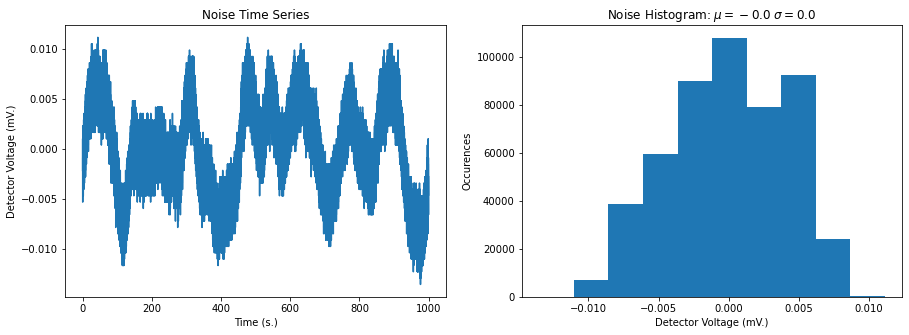

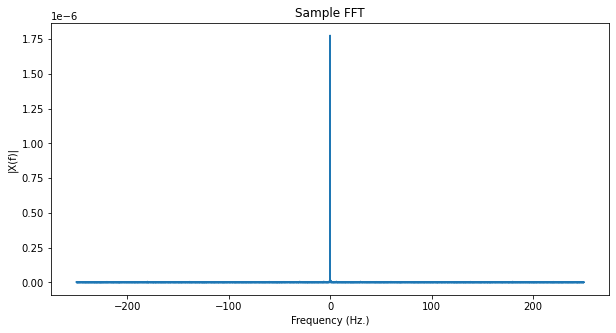

In [6]:
%matplotlib inline
int_t = np.linspace(1, 2000, 100)
plot_time_hist(NoiseDf['Time'], NoiseDf['Voltage'], plot_title='Noise')
NoiseFs = 1/(NoiseDf['Time'][1] - NoiseDf['Time'][0])
NoiseFFT = fft(NoiseDf['Voltage'].values, NoiseFs, plot=True)


#### No Attenuation Time Series and FFT

C:\Users\thoma\Studies\SPHEREx\SW-Dev\SPHEREx-lab-tools\SPHEREx-Calibration-Automation\notebooks\Sapphire Window Coating Measurements\Support_Functions.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, plts = plt.subplots(1,2, figsize=(15,5))


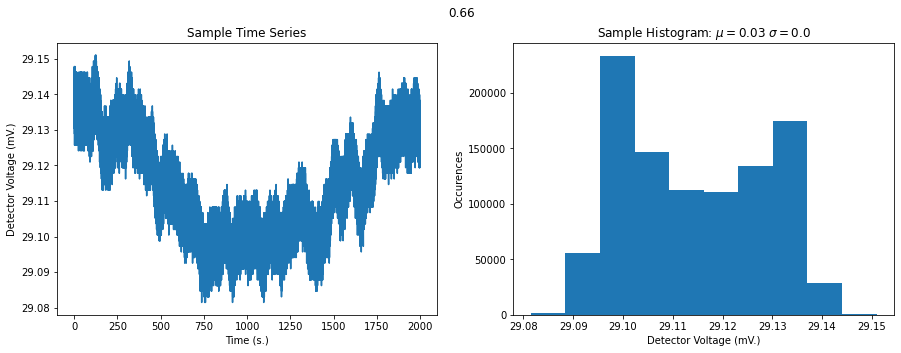

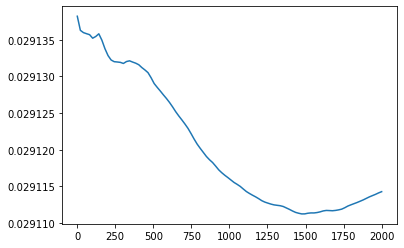

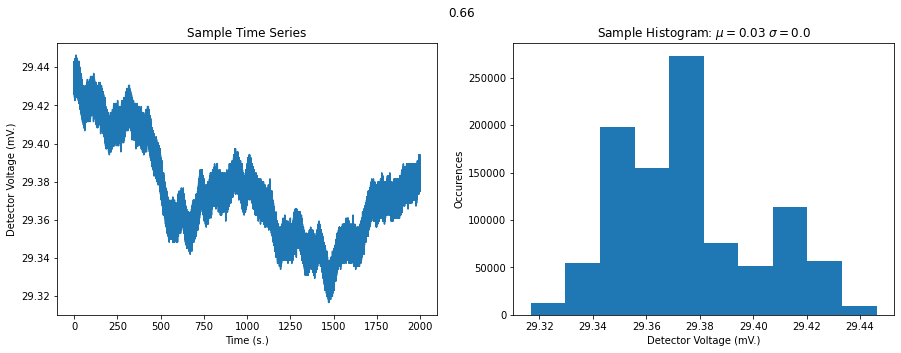

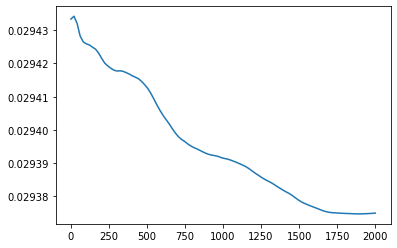

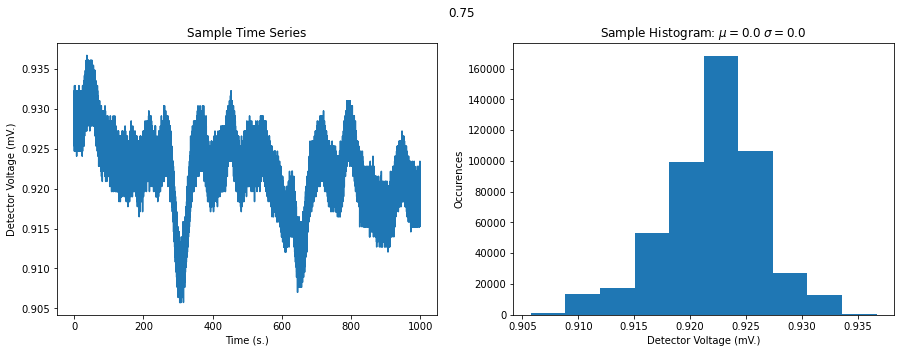

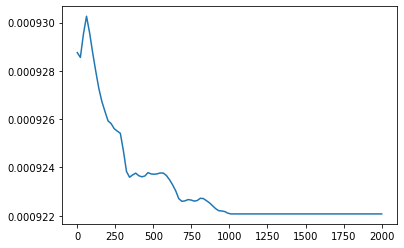

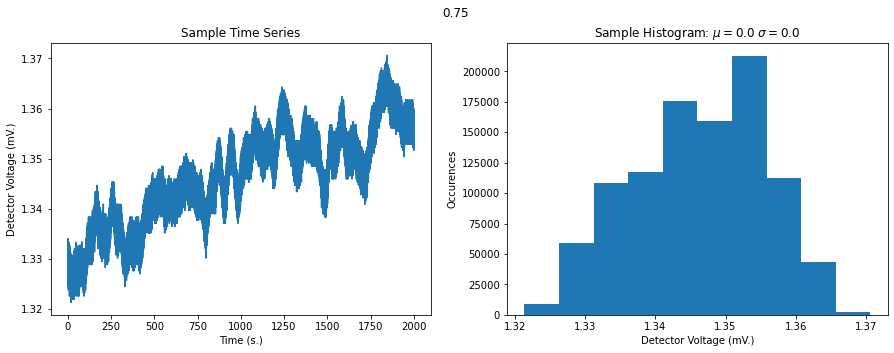

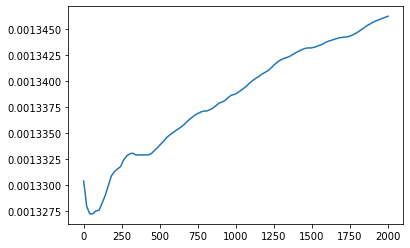

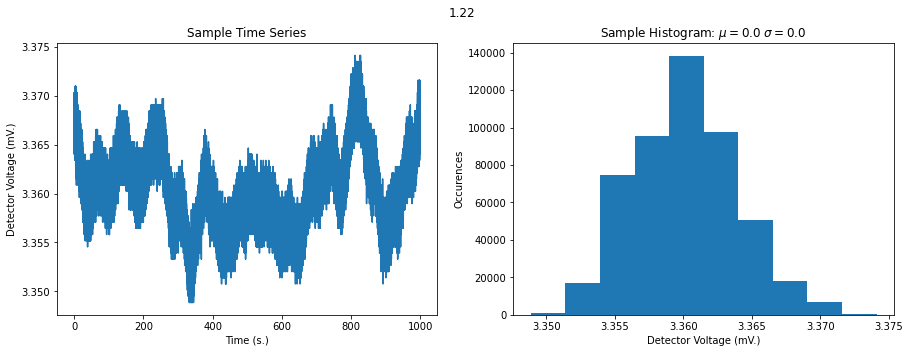

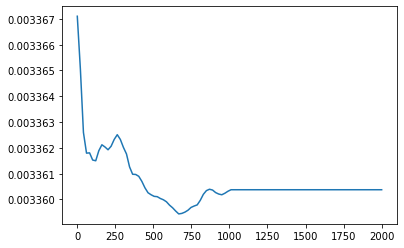

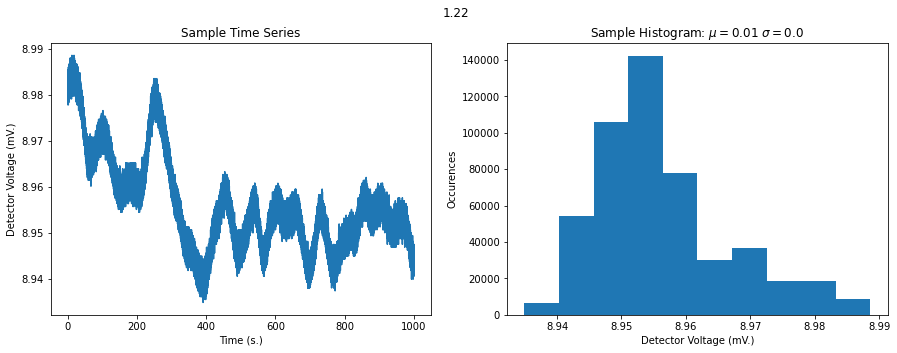

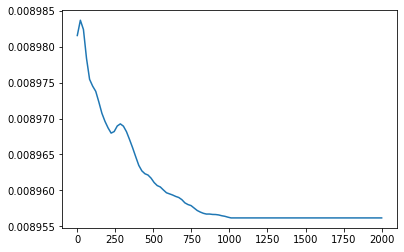

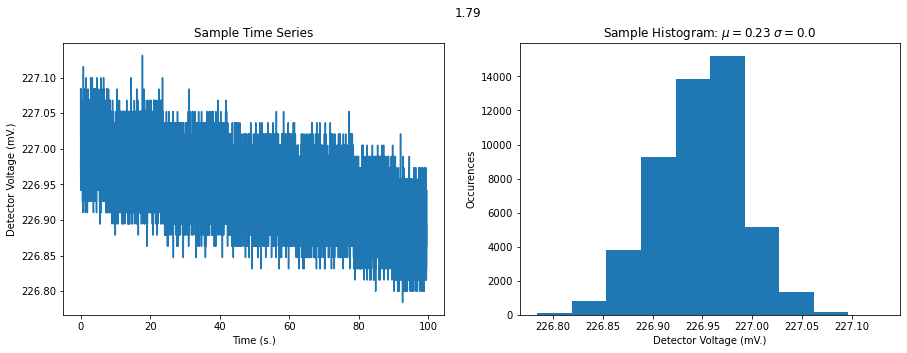

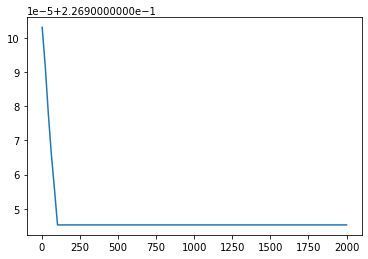

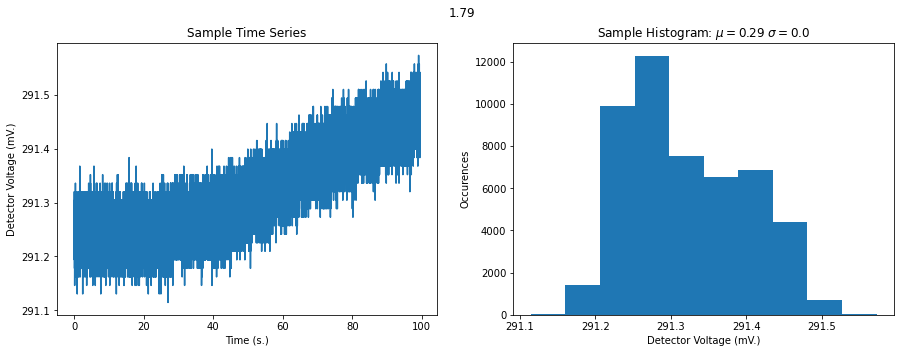

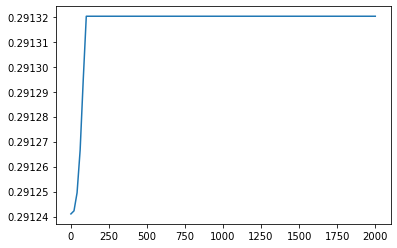

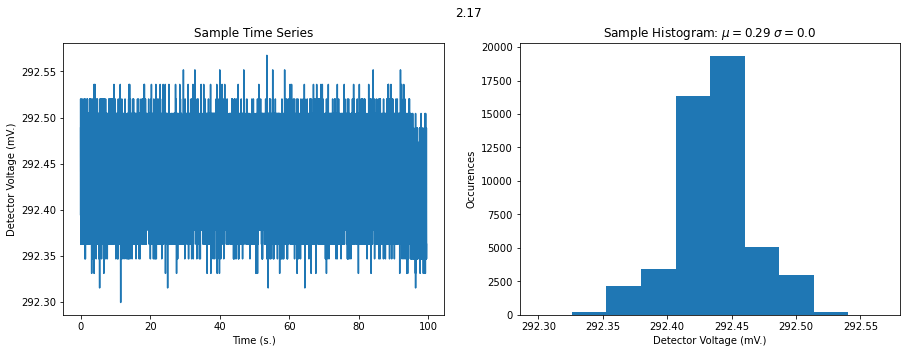

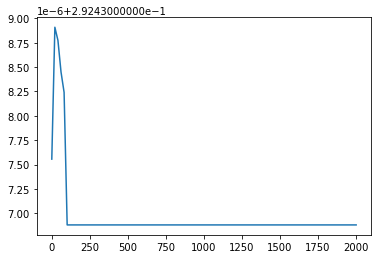

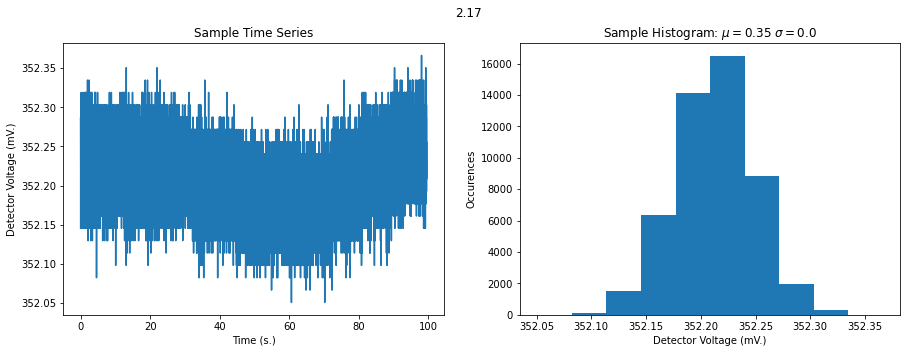

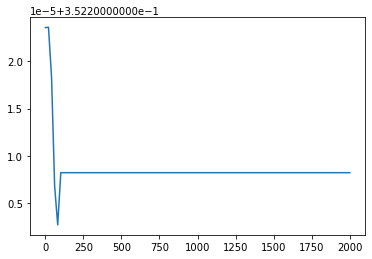

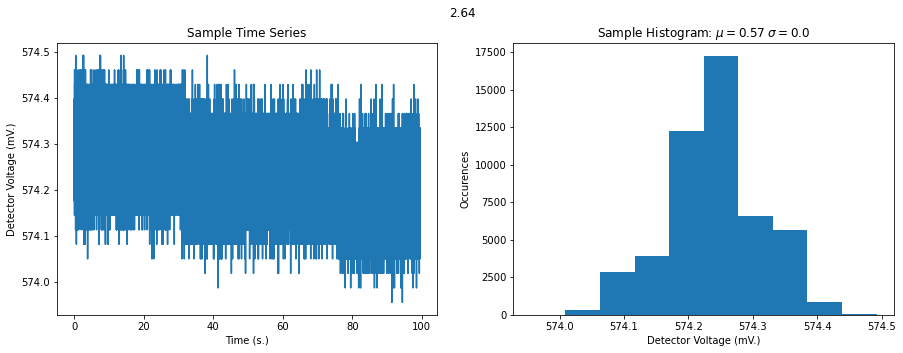

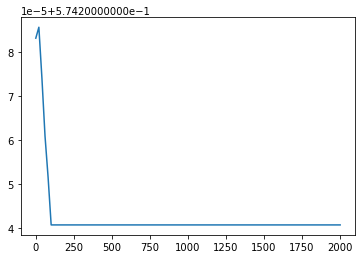

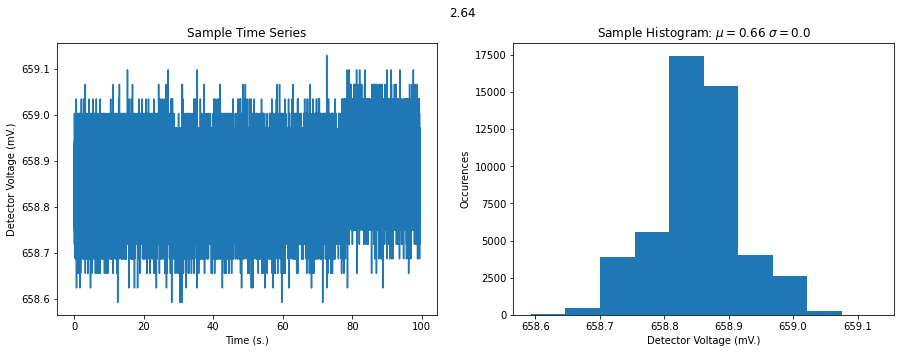

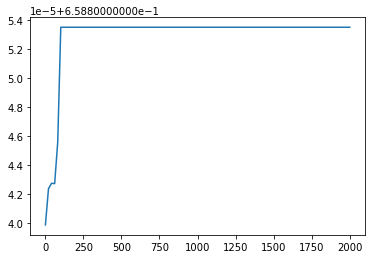

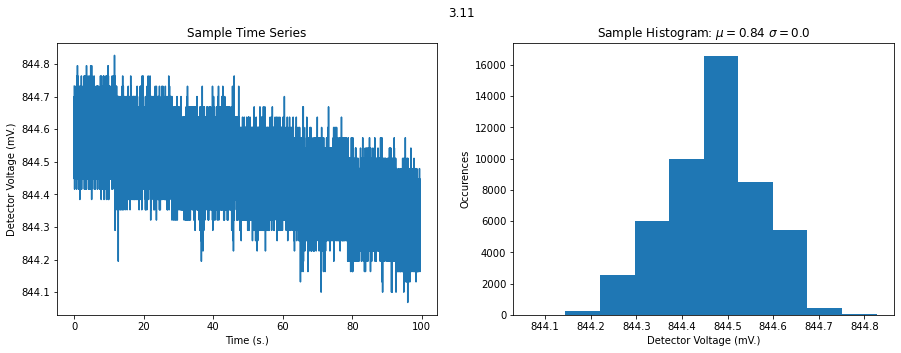

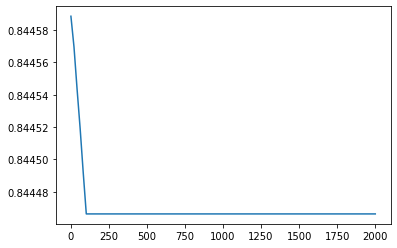

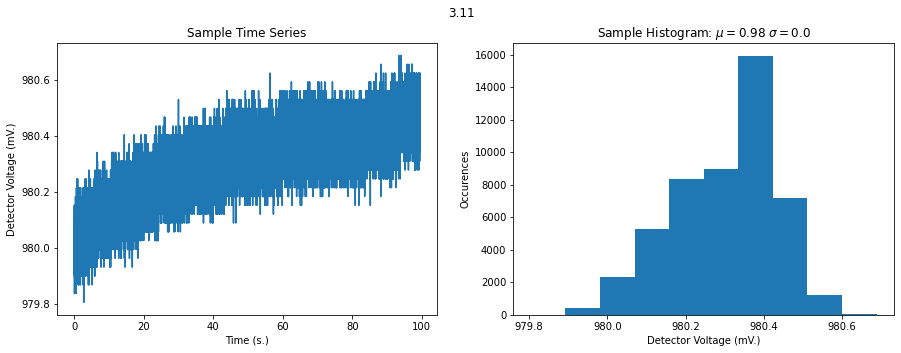

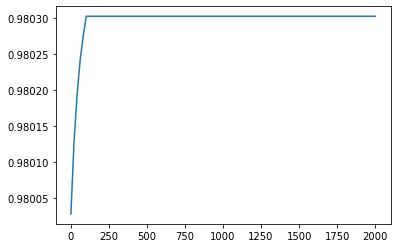

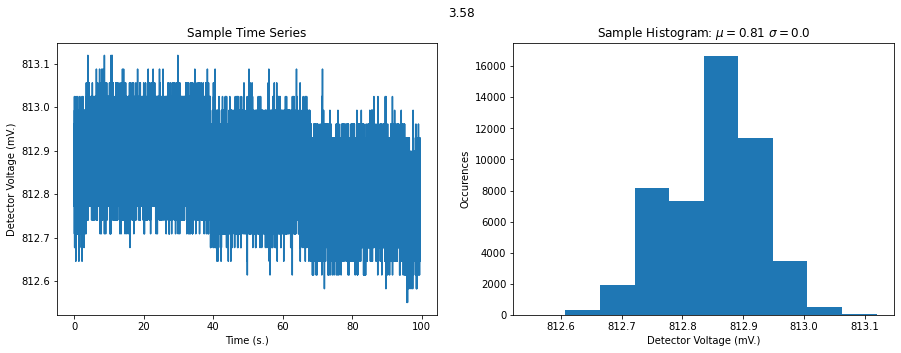

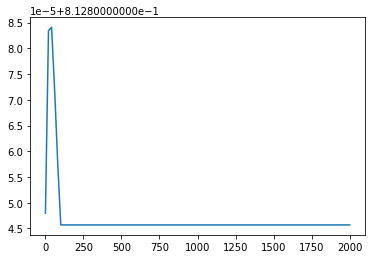

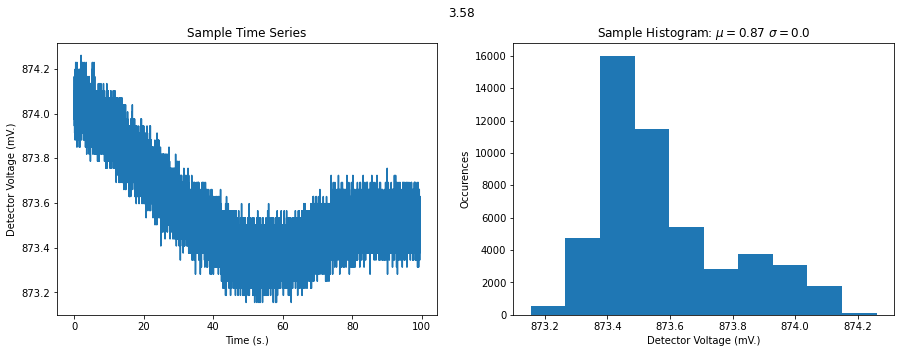

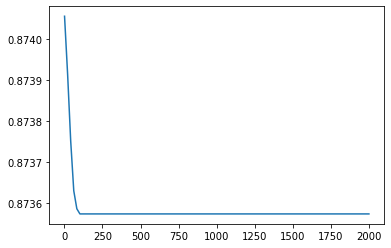

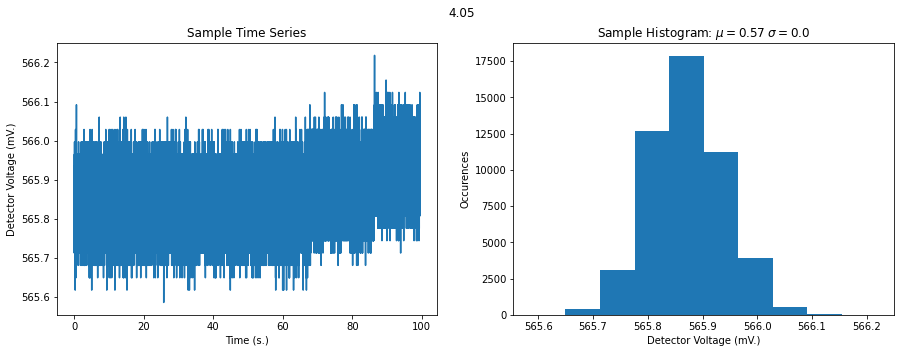

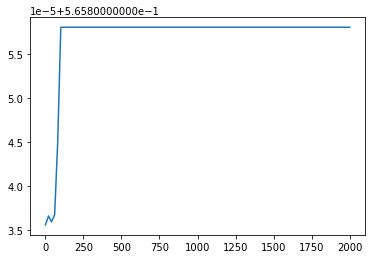

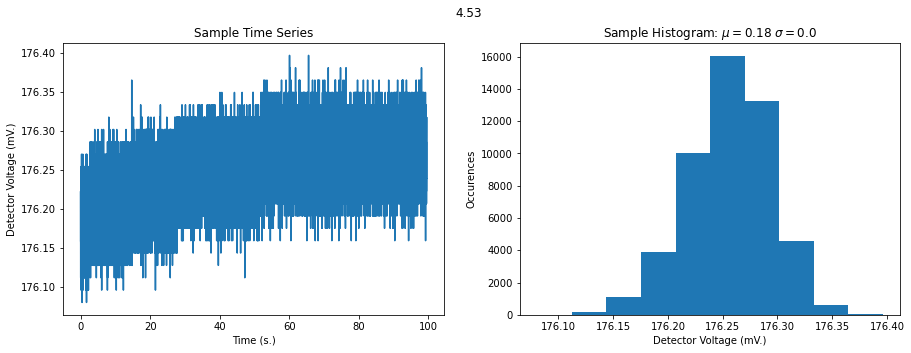

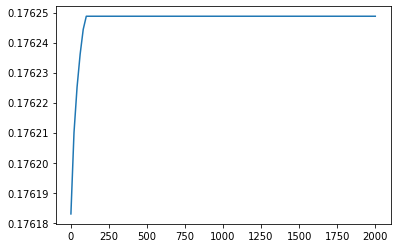

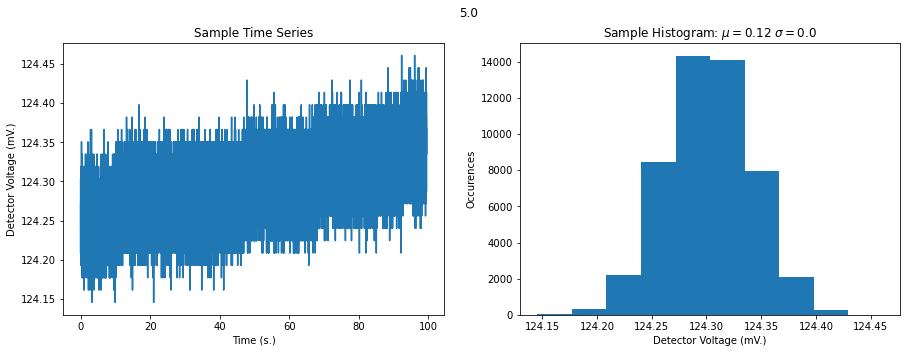

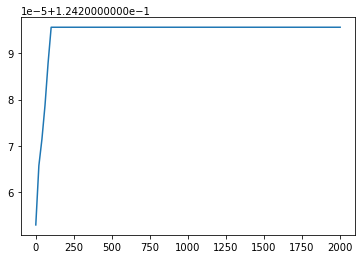

In [7]:
##THORLABS SOURCE###################################################

%matplotlib inline
int_t = np.linspace(1, 2000, 100)
multiple_ts_fft(SigNoAttenDf, np.unique(SigNoAttenWaves), int_t=int_t)

#### Sapphire Coating Attenuated Time Series and FFT

C:\Users\thoma\Studies\SPHEREx\SW-Dev\SPHEREx-lab-tools\SPHEREx-Calibration-Automation\notebooks\Sapphire Window Coating Measurements\Support_Functions.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, plts = plt.subplots(1,2, figsize=(15,5))


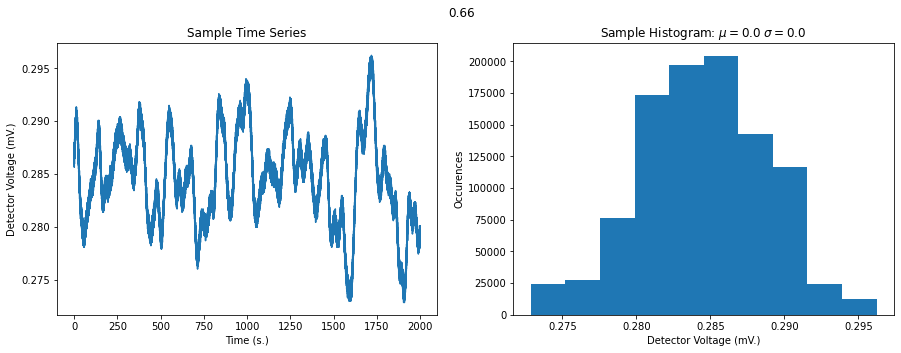

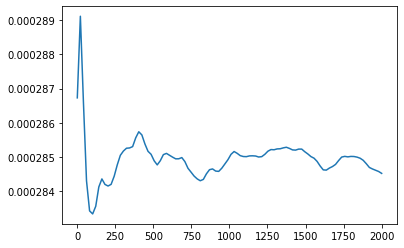

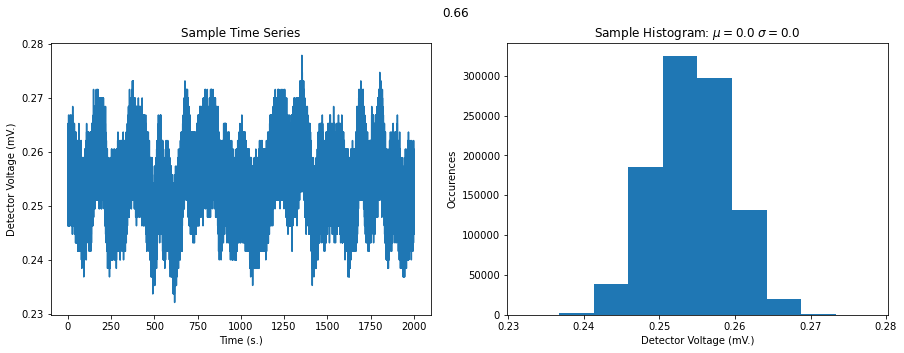

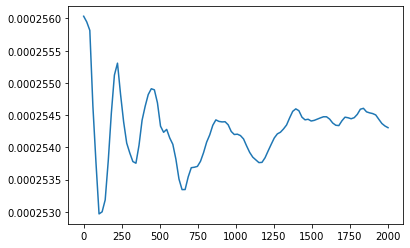

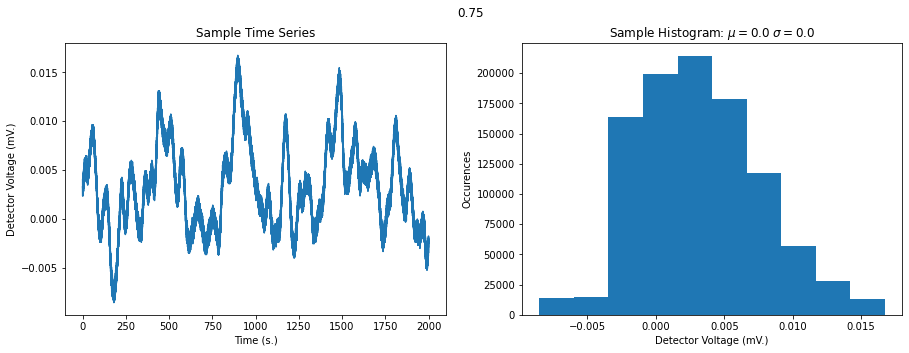

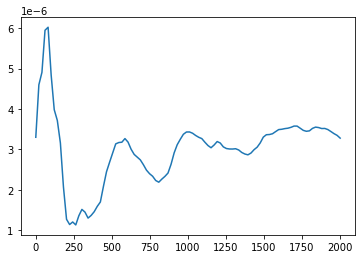

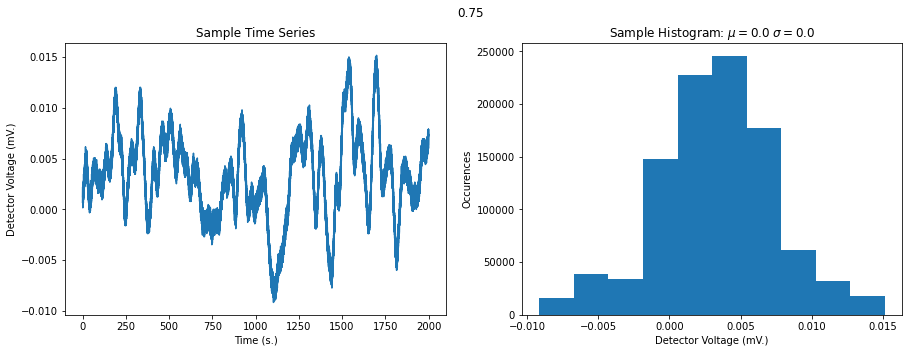

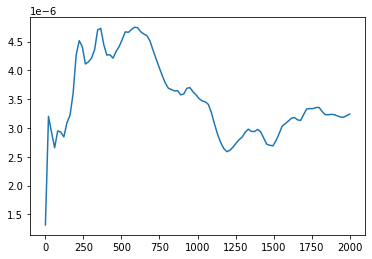

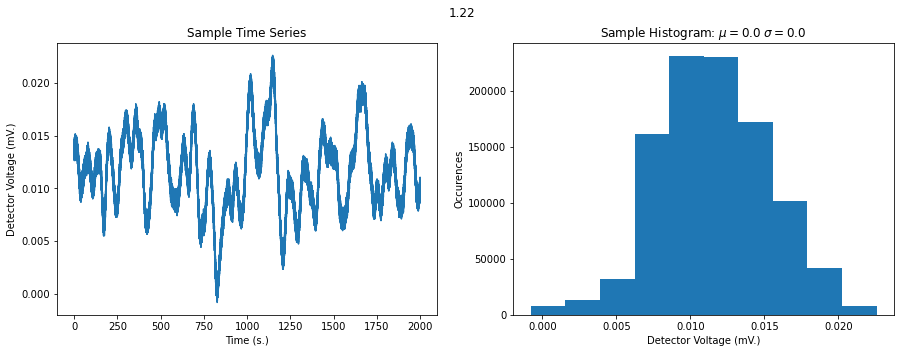

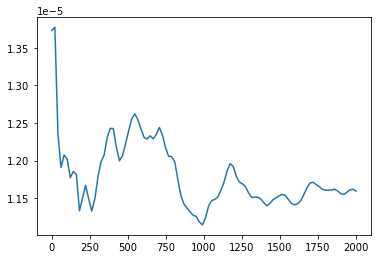

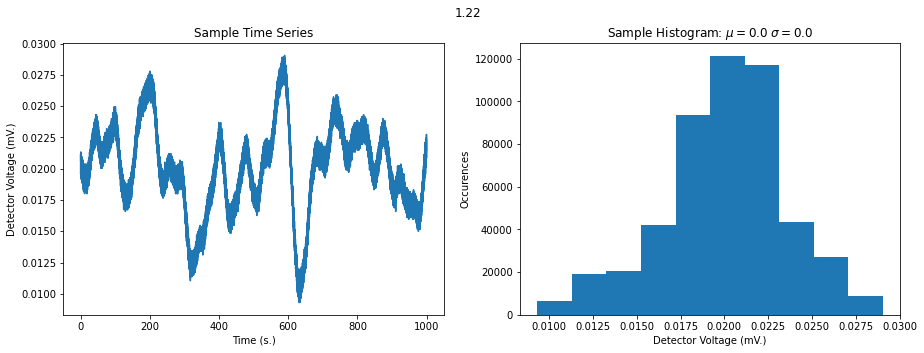

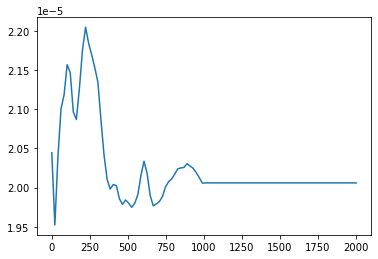

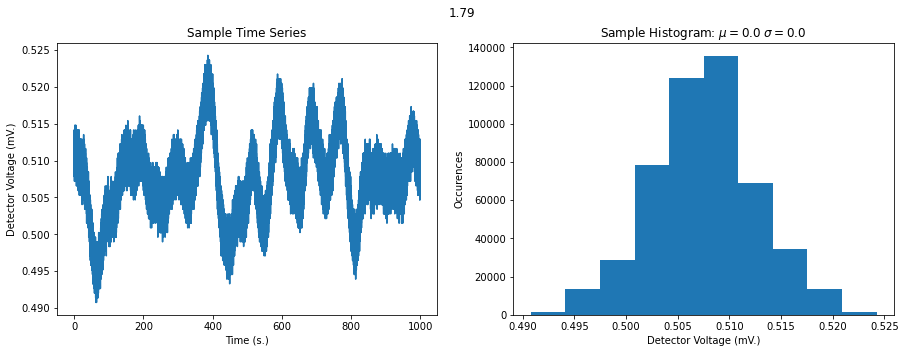

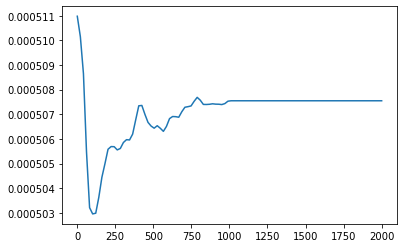

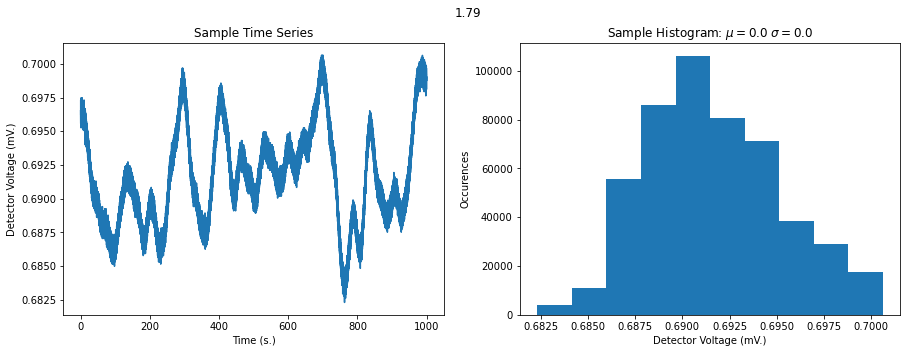

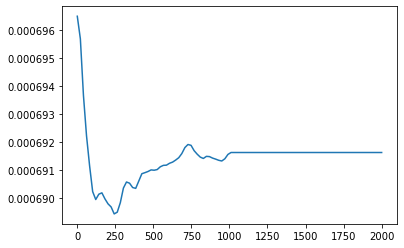

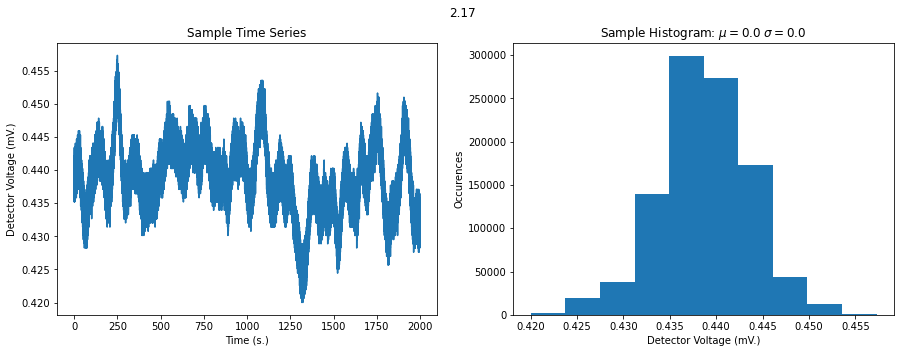

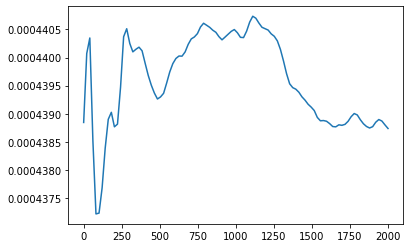

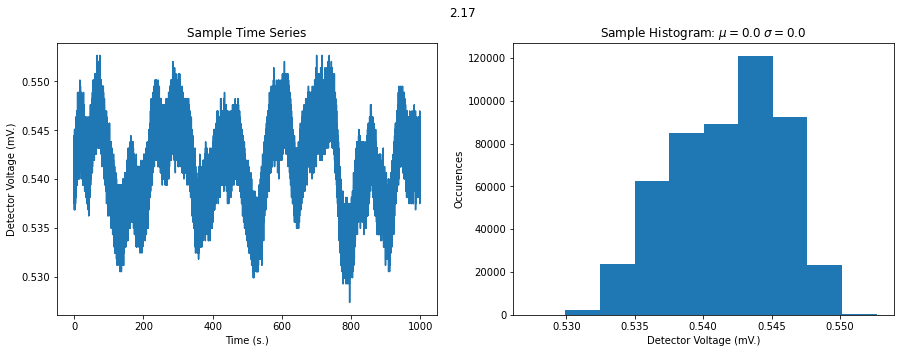

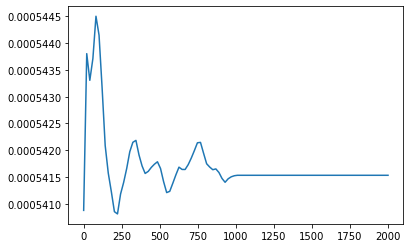

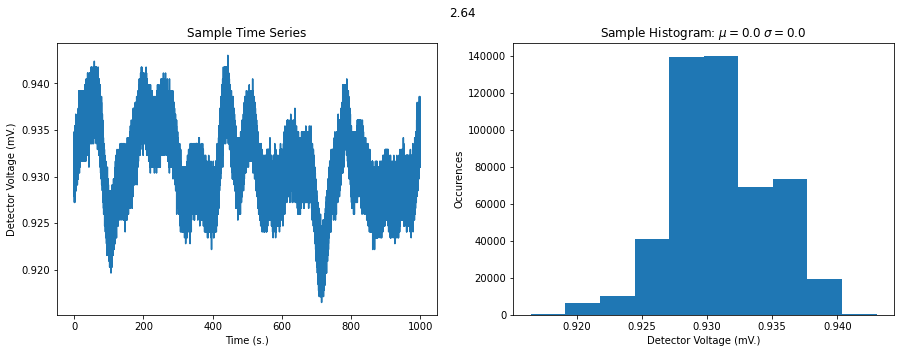

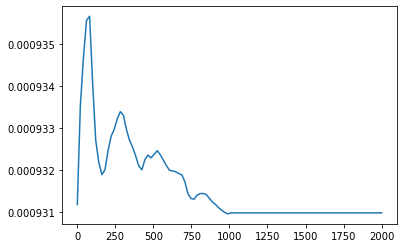

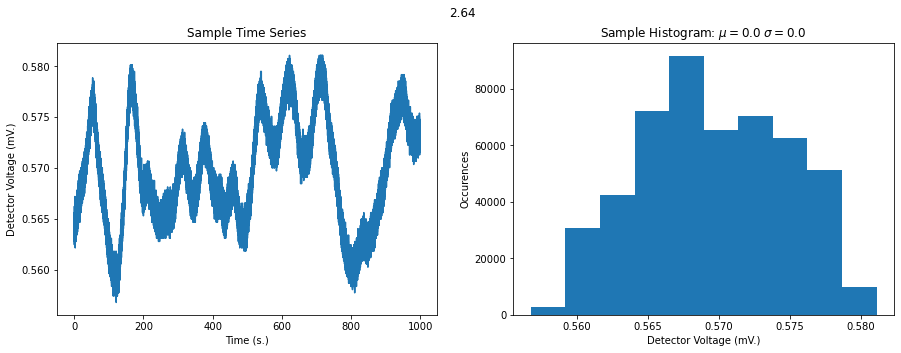

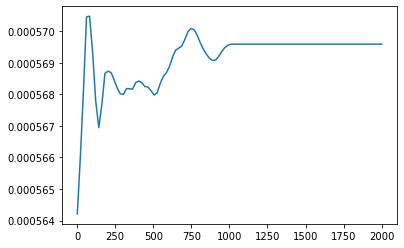

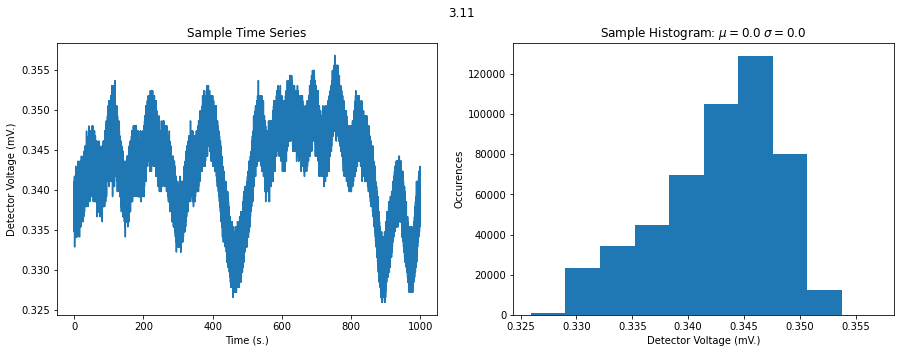

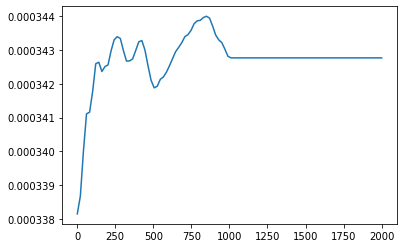

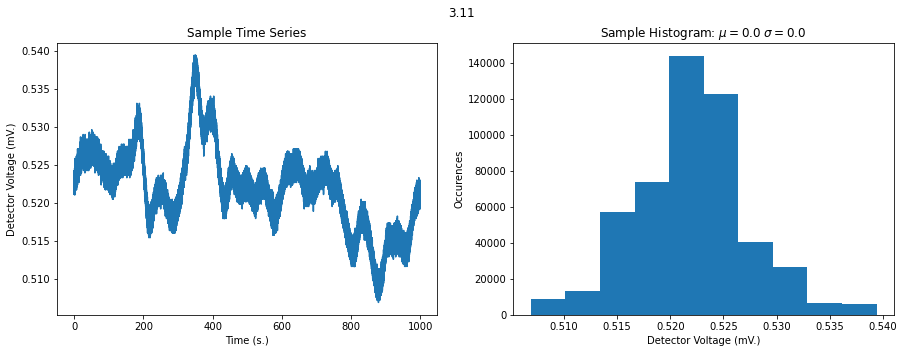

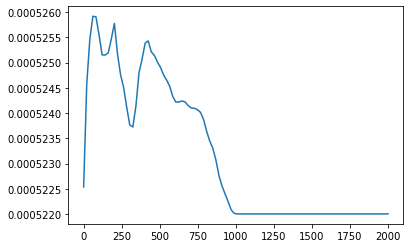

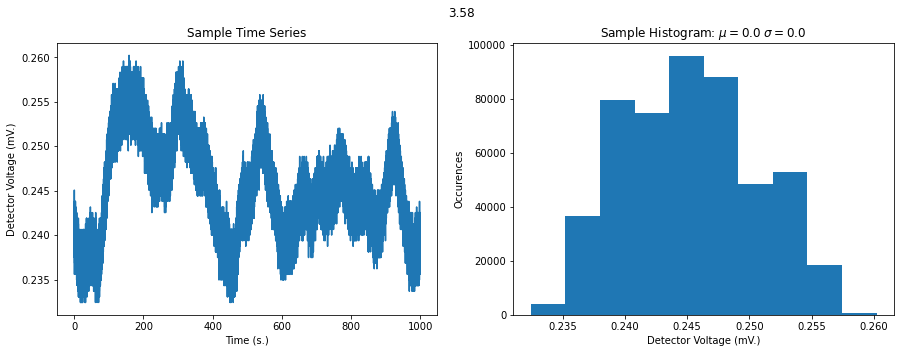

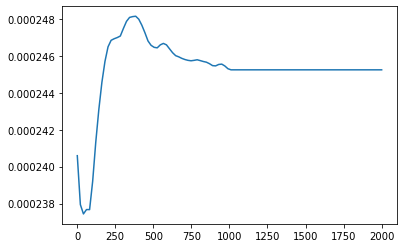

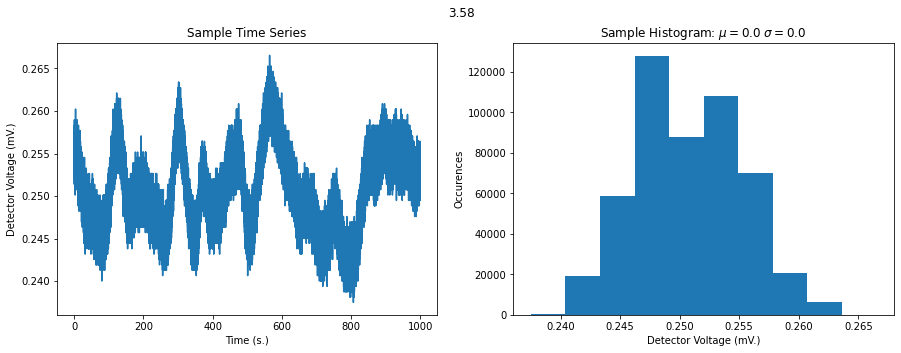

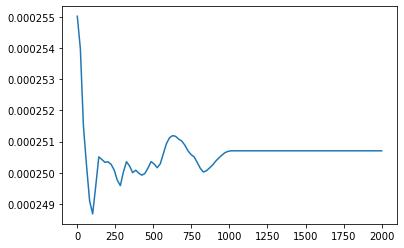

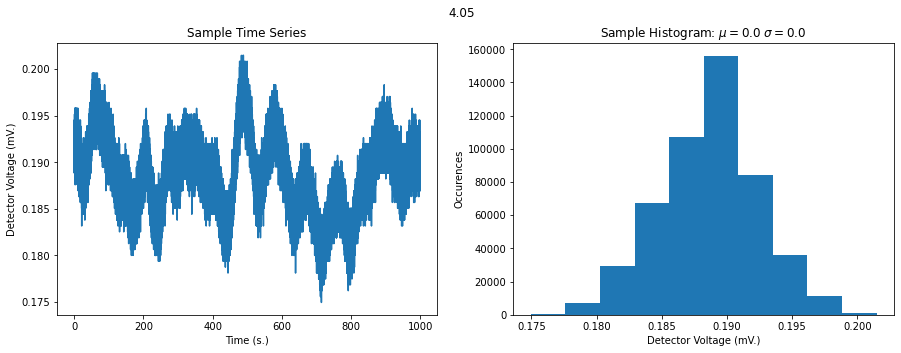

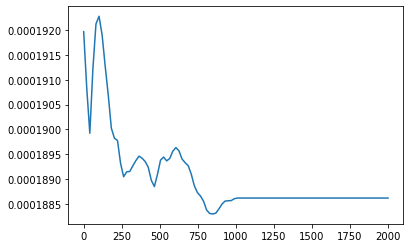

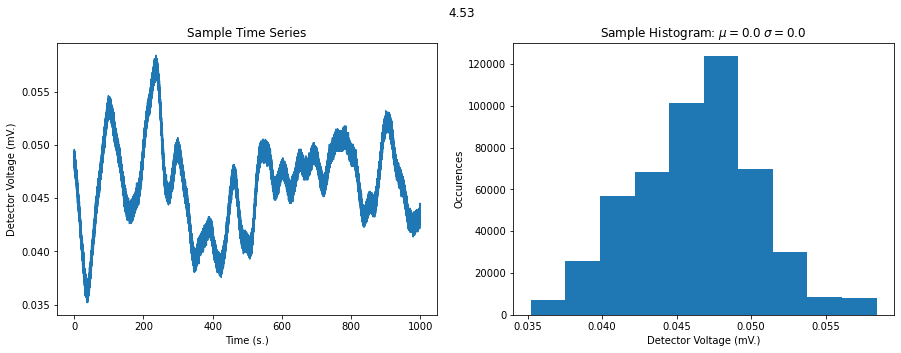

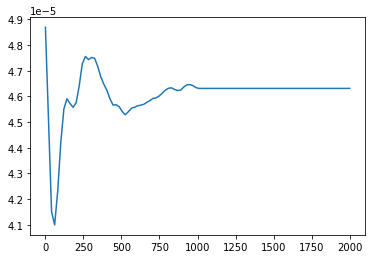

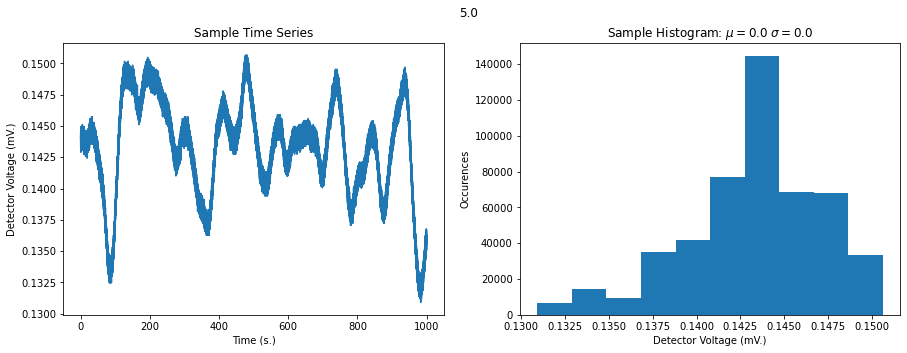

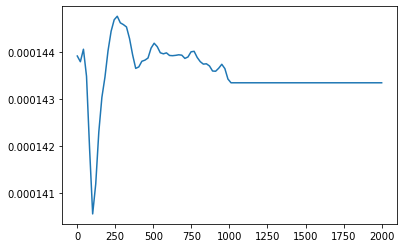

In [8]:
%matplotlib inline
int_t = np.linspace(1, 2000, 100)
multiple_ts_fft(SigAttenDf, np.unique(SigAttenWaves), int_t=int_t)

#### Rms noise power as function of integration time

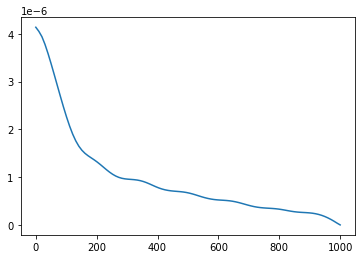

In [9]:
%matplotlib inline
IntT = np.linspace(0.01, 1000, 100)
NoisePowersRms = np.zeros(len(IntT))
ind = 0
for t in IntT:
    NoisePowersRms[ind] = fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], t)
    ind += 1

#print(NoisePowersRms)
plt.plot(IntT, NoisePowersRms)

## SNR as Function of Wavelength for all Sources Used

In [84]:
%matplotlib qt
int_t = 998

sig_noatten_powers = np.zeros(len(SigNoAttenWaves))
ind = 0
for w in SigNoAttenWaves:
    df = SigNoAttenDf[SigNoAttenDf['Type'].isin([w])]
    fs = 1/(df['Time'].values[1] - df['Time'].values[0])
    
    voltages = df['Voltage'].values
                 #   - NoiseDf['Voltage'].values #voltages w/ noise removed
    #compute signal voltage
    sig_noatten_powers[ind] = voltages.mean()
    ind += 1

rms_noise_power = fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], int_t=int_t)
snr_curve = sig_noatten_powers / rms_noise_power

fig, ax = plt.subplots()

print('Wavelengths: ')
print(SigNoAttenWaves)
print('SNRs:')
print(snr_curve)
ax.scatter(SigNoAttenWaves, snr_curve, s=6)
ax.set_xlabel(r'Wavelength ($\mu m.$)')
ax.hlines(1e5, xmin=0.7, xmax=5.5, color='red', linestyles='dotted')
ax.set_ylabel('SNR')
ax.set_yscale('log')
ax.set_title('SNR vs. Wavelength w/ 1000s. Integration'.format(int_t))

Wavelengths: 
[0.66 0.66 0.75 0.75 1.22 1.22 1.79 1.79 2.17 2.17 2.64 2.64 3.11 3.11
 3.58 3.58 4.05 4.05 4.53 4.53 5.   5.  ]
SNRs:
[4.74529945e+06 4.74529945e+06 1.95506935e+05 1.95506935e+05
 9.99257156e+05 9.99257156e+05 4.20475014e+07 4.20475014e+07
 5.23008291e+07 5.23008291e+07 1.00042404e+08 1.00042404e+08
 1.48045723e+08 1.48045723e+08 1.36821164e+08 1.36821164e+08
 8.78213326e+07 8.78213326e+07 2.37246368e+07 2.37246368e+07
 2.30676234e+07 2.30676234e+07]


Text(0.5, 1.0, 'SNR vs. Wavelength w/ 1000s. Integration')

## Required Integration time as function of wavelength for a given SNR

In [27]:
SNR = 1e5
int_t = np.linspace(1, 999, 1000)
int_t_inds = np.ones(len(SigNoAttenWaves))

i0 = 0
for w in SigNoAttenWaves:
    sig_voltages = SigNoAttenDf[SigNoAttenDf['Type'].isin([w])]['Voltage']
    sig = sig_voltages.mean()
    i1 = 0
    for t in int_t:
        if sig/fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], int_t=t) >= SNR:
            int_t_inds[i0] = i1
            break
        i1 += 1
    i0 += 1

integration_times = [int_t[int(ind)] for ind in int_t_inds]
    
print(integration_times)

[835.1641641641642, 835.1641641641642, 997.002002002002, 997.002002002002, 985.014014014014, 985.014014014014, 85.91491491491492, 85.91491491491492, 57.94294294294294, 57.94294294294294, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 131.86886886886887, 216.78378378378378]


In [20]:
%matplotlib qt
fig, ax = plt.subplots()

ax.plot(SigNoAttenWaves, integration_times, label='1e5')
ax.set_title('Required Integration Time for Fixed SNR')
ax.set_ylabel('Integration Time (s.)')
ax.set_xlabel(r'Wavelength $\mu$m.')
ax.legend()

## Transmission Profile

In [72]:
wave_num = len(np.unique(SigAttenWaves))
Transmissions = np.zeros(wave_num)
TransmissionsAll = []
TransmissionsStandards = np.zeros(wave_num)
NoAttenOutputIntensity = np.zeros(wave_num)
NoAttenOutputIntensityAll = []
ind = 0
for w in np.unique(SigAttenWaves):    
    noatten_df = SigNoAttenDf[SigNoAttenDf['Type'].isin([w])]
    noatten_voltages = noatten_df['Voltage'].values
    atten_df = SigAttenDf[SigAttenDf['Type'].isin([w])]
    atten_voltages = atten_df['Voltage'].values
    
    '''
    Transmissions[ind] = atten_voltages.mean() / noatten_voltages.mean()
    ind += 1
    '''
    
    
    noatten_times = noatten_df['Time'].values
    noatten_zeros_ind = np.where(noatten_times==0)
    noatten_zeros_ind = np.append(noatten_zeros_ind, -1)
    
    atten_times = atten_df['Time'].values
    atten_zeros_ind = np.where(atten_times==0)
    atten_zeros_ind = np.append(atten_zeros_ind, -1)
    
    noatten_voltages = [np.array(noatten_voltages[noatten_zeros_ind[i]:noatten_zeros_ind[i+1]]) 
                        for i in range(len(noatten_zeros_ind) - 1)]

    atten_voltages = [np.array(atten_voltages[atten_zeros_ind[i]:atten_zeros_ind[i+1]]) 
                        for i in range(len(atten_zeros_ind) - 1)]
    
    transmissions_ind = np.zeros(len(noatten_voltages))
    noatten_output = np.zeros(len(noatten_voltages))
    for i in range(len(noatten_voltages)):
        transmissions_ind[i] =  atten_voltages[i].mean() / noatten_voltages[i].mean()
        noatten_output[i] = noatten_voltages[i].mean()
        
    transmissions_ind *= 1e2
    TransmissionsAll.append(transmissions_ind)
    Transmissions[ind] = transmissions_ind.mean()
    TransmissionsStandards[ind] = transmissions_ind.std()
    NoAttenOutputIntensityAll.append(noatten_output)
    NoAttenOutputIntensity[ind] = noatten_output.mean()
    ind += 1
    
TransmissionsAll = [t for transmissions_list in TransmissionsAll for t in transmissions_list]
NoAttenOutputIntensityAll = [out for out_list in NoAttenOutputIntensityAll for out in out_list]

#### Mean transmissions and 3 sigma error bars

In [57]:
%matplotlib qt

fig, ax = plt.subplots()

ax.scatter(np.unique(SigAttenWaves), Transmissions)
ax.errorbar(np.unique(SigAttenWaves), Transmissions, yerr=1*TransmissionsStandards, linestyle='None')
ax.set_title('Measured Filter Transmission')
ax.set_ylabel('Transmission (%)')
ax.set_xlabel(r'Wavelength $\mu$m.')

Text(0.5, 0, 'Wavelength $\\mu$m.')

#### All measured transmissions

In [80]:
%matplotlib qt
fig, ax = plt.subplots()

ax.scatter(SigAttenWaves, TransmissionsAll, s=4)
ax.plot(np.unique(SigAttenWaves), Transmissions, 
        linestyle='-.', linewidth=0.4, color='red')
ax.set_title('Measured Filter Transmission')
ax.set_ylabel('Transmission (%)')
ax.set_xlabel(r'Wavelength $\mu$m.')

Text(0.5, 0, 'Wavelength $\\mu$m.')

## Monochromator Output Intensity

In [81]:
%matplotlib qt
fig, ax = plt.subplots()

ax.scatter(SigAttenWaves, NoAttenOutputIntensityAll, s=4)
ax.plot(np.unique(SigAttenWaves), NoAttenOutputIntensity,
        linestyle='-.', linewidth=0.4, color='red')
ax.set_title('Monochromator Output Intensity')
ax.set_xlabel(r'Wavelength $\mu$m.')
ax.set_ylabel('Detector RMS Output Voltage (V.)')

Text(0, 0.5, 'Detector RMS Output Voltage (V.)')

## Verifications

#### Verification of fft routine

In [ ]:
fs = 30
t = np.arange(-1, 1, 1/fs)
f = 2
test_sig = 3 + 3*np.sin(2*np.pi*f*t) + 2*np.cos(2*2*f*np.pi*t)
ts_fft = fft(test_sig, fs)

#### Verification of fft_power_calc

In [ ]:
int_t = 100

#Generate moving average filter corresponding to given integration time and perform filtering in time
ma_N = int(int_t*NoiseFs)
ma_filter = (1/ma_N)*np.ones(ma_N)
noise_integrated = np.convolve(ma_filter, NoiseDf['Voltage'].values)
nf_power = fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], int_t=int_t)

print(np.sqrt((noise_integrated**2).mean()))
print(nf_power)




In [ ]:
np.sqrt((NoiseDf['Voltage'].values**2).mean())

In [ ]:
fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'])

#### Verification of rms noise power vs integration time

In [ ]:
%matplotlib inline
IntT = [800]
NoisePowersRmsFft = np.zeros(len(IntT))
NoisePowersRmsMa = np.zeros(len(IntT))
ind = 0
for t in IntT:
    #Generate moving average filter corresponding to given integration time and perform filtering in time
    ma_N = int(t*NoiseFs)
    ma_filter = (1/ma_N)*np.ones(ma_N)
    noise_integrated = np.convolve(ma_filter, NoiseDf['Voltage'].values)
    NoisePowersRmsMa[ind] = np.sqrt((noise_integrated**2).mean())
    NoisePowersRmsFft[ind] = fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], t)
    ind += 1


In [ ]:
print(NoisePowersRmsFft)
print(NoisePowersRmsMa)

In [ ]:
%matplotlib qt
fig, ax = plt.subplots()

ax.plot(IntT, NoisePowersRmsFft, label='FFT based')
ax.plot(IntT, NoisePowersRmsMa, label='Box-car')
ax.legend(fontsize=40)